In [313]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import itertools
from sklearn.preprocessing import StandardScaler #data scaling
from sklearn import decomposition #PCA
#import other python scripts for further anlaysis
import reshape
#import results
import warnings
warnings.filterwarnings("ignore")


import permuteROI
train_sub, clf, memFC,semFC,glassFC,motFC, restFC=permuteROI.modelAll_byRow('MSC05')

In [1]:
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
import permuteROI
for sub in subList:
    permuteROI.modelAll_byRow(sub)

In [17]:
train_sub='MSC01'
splitDict=dict([('MSC01',10),('MSC02',10),('MSC03',8),('MSC04',10),('MSC05',10),('MSC06',9),('MSC07',9),('MSC10',10)])
split=splitDict[train_sub]

In [2]:
import permuteROI
df

NameError: name 'df' is not defined

In [3]:
df.to_csv('/Users/Alexis/Desktop/MSC_Alexis/analysis/output/results/permutation/ALL/ref_acc.csv')

In [314]:
def permuteIndices_byRow(Xtrain_task,Xtrain_rest,rowID):
    """
    Permute rows of networks and switch tast and rest
    Parameters
    -----------
    taskFC: numpy array
        nsess x ROI
    restFC: numpy array
        nsess x ROI
    network: str
        particular network of interest
    Returns
    ------------
    taskFC, restFC : Array of task and rest FC permuting specific rows
    """
    XtrainNew_task=Xtrain_task.copy()
    XtrainNew_rest=Xtrain_rest.copy()
    indices=reshape.getIndices()
    index=indices.index
    condition=indices['level_1']==rowID
    ROI=index[condition]
    ROI_list=ROI.tolist()
    tmpTask=XtrainNew_task[:,ROI_list]
    tmpRest=XtrainNew_rest[:,ROI_list]
    #permute values
    rng = np.random.default_rng()
    #tmpTask_permute=rng.permutation(tmpTask,axis=1)#permute across rows
    #tmpRest_permute=rng.permutation(tmpRest,axis=1)
    tmpT_permute=rng.permutation(tmpTask)#then permute across columns 
    tmpR_permute=rng.permutation(tmpRest)
    #tmpTask_permute=np.random.permutation(tmpTask)
    #tmpRest_permute=np.random.permutation(tmpRest)
    #Now switch
    XtrainNew_task[:,ROI_list]=tmpR_permute
    XtrainNew_rest[:,ROI_list]=tmpT_permute
    return XtrainNew_task, XtrainNew_rest

In [315]:

thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
refROI=pd.read_csv(thisDir+'output/results/permutation/ALL/ref_acc.csv') #for taking differece
refROI.drop(columns=['diff_sub'],inplace=True)
ref=refROI[refROI['train']==train_sub].same_sub.values
ref_sub=ref[0] #use this to calculate difference
results=np.empty((332))#store results to use for plotting take diff from ref_sub per row and store here
kf = KFold(n_splits=5)
for rowID, null in enumerate(results):

    CVacc=[]
    df=pd.DataFrame()
    #fold each training set
    for train_index, test_index in kf.split(memFC):
        memtrain, memval=memFC[train_index], memFC[test_index]
        semtrain, semval=semFC[train_index], semFC[test_index]
        mottrain, motval=motFC[train_index], motFC[test_index]
        glatrain, glaval=glassFC[train_index], glassFC[test_index]
        Xtrain_task=np.concatenate((memtrain,semtrain,mottrain,glatrain))
        Xtrain_rest, Xval_rest=restFC[train_index,:,:], restFC[test_index,:,:]
        Xval_task=np.concatenate((memval,semval,motval,glaval))
        Xtrain_rest=np.reshape(Xtrain_rest,(-1,55278))
        Xval_rest=np.reshape(Xval_rest,(-1,55278))

        XtrainNew_task, XtrainNew_rest=permuteIndices_byRow(Xtrain_task,Xtrain_rest,rowID)#permute specific indices
        ytrain_task = np.ones(Xtrain_task.shape[0], dtype = int)
        ytrain_rest=np.zeros(Xtrain_rest.shape[0], dtype=int)
        yval_task = np.ones(Xval_task.shape[0], dtype = int)
        yval_rest=np.zeros(Xval_rest.shape[0], dtype=int)
        X_tr=np.concatenate((XtrainNew_task, XtrainNew_rest))
        X_val=np.concatenate((Xval_task, Xval_rest))
        y_tr = np.concatenate((ytrain_task,ytrain_rest))
        y_val=np.concatenate((yval_task, yval_rest))
        clf.fit(X_tr,y_tr)
        #cross validation
        CV_score=clf.score(X_val,y_val) 

        CVacc.append(CV_score)
    df['cv']=CVacc
    #Different sub outer acc
    same_sub_score=df['cv'].mean()
    #print(same_sub_score)
    diff=same_sub_score-ref_sub
    results[rowID]=diff


In [312]:
results

array([ 0.    , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.0375,
       -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 ,
       -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 ,
       -0.025 , -0.025 , -0.025 ,  0.    , -0.025 , -0.025 , -0.025 ,
       -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 ,
        0.    , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 ,
       -0.025 , -0.025 , -0.025 , -0.025 , -0.025 ,  0.    , -0.025 ,
       -0.025 , -0.025 ,  0.    , -0.025 , -0.025 , -0.025 , -0.025 ,
       -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 ,
       -0.025 , -0.025 , -0.025 , -0.025 ,  0.    , -0.025 , -0.025 ,
       -0.025 , -0.025 , -0.025 , -0.025 ,  0.    , -0.025 , -0.025 ,
       -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 ,
       -0.025 , -0.025 ,  0.    , -0.025 , -0.025 , -0.025 , -0.025 ,
       -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 , -0.025 ,
       -0.025 , -0.0

In [301]:
bar=foo[foo!=0]

In [302]:
bar.shape

(10624,)

In [259]:
diff

0.0

In [293]:
XtrainNew_task=Xtrain_task.copy()
XtrainNew_rest=Xtrain_rest.copy()
indices=reshape.getIndices()
index=indices.index
condition=indices['level_1']==0
ROI=index[condition]
ROI_list=ROI.tolist()
tmpTask=XtrainNew_task[:,ROI_list]
tmpRest=XtrainNew_rest[:,ROI_list]
#permute values
rng = np.random.default_rng()
#tmpTask_permute=rng.permutation(tmpTask,axis=1)#permute across rows
#tmpRest_permute=rng.permutation(tmpRest,axis=1)
tmpT_permute=rng.permutation(tmpTask)#then permute across columns 
tmpR_permute=rng.permutation(tmpRest)
#tmpTask_permute=np.random.permutation(tmpTask)
#tmpRest_permute=np.random.permutation(tmpRest)
#Now switch
XtrainNew_task[:,ROI_list]=tmpR_permute
XtrainNew_rest[:,ROI_list]=tmpT_permute

In [298]:
tmpTask.shape

(32, 332)

In [245]:
c

array([[6, 5, 4],
       [3, 2, 1]])

In [131]:
semFC[0]

array([0.33498504, 0.20321288, 0.6444301 , ..., 0.53283229, 0.41349605,
       0.84330897])

In [86]:
import matlab.engine
import scipy.io
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
df='/Users/Alexis/Desktop/MSC_Alexis/analysis/data/mvpa_data/mem/MSC05_parcel_corrmat.mat' #temp file for getting indices
fileFC=scipy.io.loadmat(df)
fileFC=np.array(fileFC['parcel_corrmat'])
fileFC=np.nan_to_num(fileFC)
ds=fileFC[:,:,0]
Parcel_params = reshape.loadParcelParams('Gordon333',thisDir+'data/Parcel_info/')
roi_sort = np.squeeze(Parcel_params['roi_sort'])
corrmat=ds[roi_sort,:][:,roi_sort]
nrois=list(range(333))
nets=[]
position=0
count=0
networks=Parcel_params['networks']
t=Parcel_params['transitions']
#have to add extra value otherwise error
transitions=np.append(t,333)
while count<333:
    if count<=transitions[position]:
        nets.append(networks[position])
        count=count+1
    else:
        position=position+1
#transform data to locate network
df=pd.DataFrame(corrmat, index=[nets, nrois], columns=[nets, nrois])
df_ut = df.where(np.triu(np.ones(df.shape),1).astype(np.bool))

In [124]:
results

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [100]:
MSC05=reshape.permROI('/Users/Alexis/Desktop/MSC_Alexis/analysis/data/mvpa_data/mem/MSC05_parcel_corrmat.mat')

In [101]:
MSC05.shape


(10, 55278)

In [120]:
indices=reshape.getIndices()
index=indices.index
taskFC=MSC05.copy()
condition=indices['level_1']==331
ROI=index[condition]
ROI_list=ROI.tolist()
tmpTask=taskFC[:,ROI_list]
#permute values
tmpTask_permute=np.random.permutation(tmpTask)
#Now switch
taskFC[:,ROI_list]=tmpTask_permute #now we purposefully swap the permuted labels to the other task/rest FC


In [106]:
MSC05[0,0]

0.2070389939728905

In [107]:
taskFC[0,0]

0.4787413083151937

In [121]:
t=MSC05-taskFC

In [122]:
t[:,55277]

array([ 0.07870691,  0.30915936,  0.06240042, -0.0430309 , -0.01129618,
        0.        ,  0.29084581, -0.25528493, -0.16954375, -0.26195674])

In [9]:
tmpTask[0][0]

0.022630871015933782

In [10]:
taskFC[0][0]

0.022630871015933782

In [11]:
import numpy as np
mask = (ttaskFC == 0).all(1)
column_indices = np.where(mask)[0]
df = ttaskFC[~mask,:]



In [12]:
df.shape

(8, 55278)

In [11]:
indices.tail()

,level_0,level_1,variable_0,variable_1,value
55273,pon,327,pon,332,0.524179
55274,pon,328,pon,332,0.443304
55275,pon,329,pon,332,0.119601
55276,pon,330,pon,332,0.574670
55277,pon,331,pon,332,0.004735


In [10]:
ttaskFC.shape

(10, 55278)

In [3]:
import numpy as np
split=np.empty((333))

In [4]:
value=111
for idx, nullVal in enumerate(split):
    split[idx]=value
    

In [6]:
split

array([111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111., 111., 111., 111., 111., 111., 111., 11

In [1]:
import permuteROI
res=permuteROI.modelAll_byRow('MSC05')

res.tofile('/Users/Alexis/Desktop/MSC_Alexis/analysis/output/results/permutation/ALL/MSC05_Row.csv', sep = ',')

,level_0,level_1,variable_0,variable_1,value
0,unassign,0,unassign,1,0.022631
1,unassign,0,unassign,2,0.117758
2,unassign,1,unassign,2,0.298062
3,unassign,0,unassign,3,0.442273
4,unassign,1,unassign,3,0.118008
...,...,...,...,...,...
55273,pon,327,pon,332,0.524179
55274,pon,328,pon,332,0.443304
55275,pon,329,pon,332,0.119601
55276,pon,330,pon,332,0.574670


In [40]:
import pandas as pd
tmp=pd.DataFrame(res,columns=['result'])
tmp.reset_index(inplace=True)
tmp.rename(columns={'index':'level_1'},inplace=True)
final=indices.merge(tmp,on='level_1')
final.drop(columns='value',inplace=True)
tmp2=final.pivot(values='result',index=['level_0','level_1'],columns=['variable_0','variable_1'])
tmp2.sort_values(by='level_1',inplace=True)


In [44]:
tmp2

variable_0       unassign                                               \
variable_1            1      2      3      4       5       6       7     
level_0  level_1                                                         
unassign 0            0.0  0.000  0.000  0.000  0.0000  0.0000  0.0000   
         1            NaN  0.025  0.025  0.025  0.0250  0.0250  0.0250   
         2            NaN    NaN  0.025  0.025  0.0250  0.0250  0.0250   
         3            NaN    NaN    NaN  0.000  0.0000  0.0000  0.0000   
         4            NaN    NaN    NaN    NaN -0.0125 -0.0125 -0.0125   
...                   ...    ...    ...    ...     ...     ...     ...   
pon      327          NaN    NaN    NaN    NaN     NaN     NaN     NaN   
         328          NaN    NaN    NaN    NaN     NaN     NaN     NaN   
         329          NaN    NaN    NaN    NaN     NaN     NaN     NaN   
         330          NaN    NaN    NaN    NaN     NaN     NaN     NaN   
         331          NaN    NaN    NaN    NaN     NaN     NaN     NaN   

variable_0                                ...     pmn                     pon  \
variable_1           8       9       10   ...     323     324     325     326   
level_0  level_1                          ...                                   
unassign 0        0.0000  0.0000  0.0000  ...  0.0000  0.0000  0.0000  0.0000   
         1        0.0250  0.0250  0.0250  ...  0.0250  0.0250  0.0250  0.0250   
         2        0.0250  0.0250  0.0250  ...  0.0250  0.0250  0.0250  0.0250   
         3        0.0000  0.0000  0.0000  ...  0.0000  0.0000  0.0000  0.0000   
         4       -0.0125 -0.0125 -0.0125  ... -0.0125 -0.0125 -0.0125 -0.0125   
...                  ...     ...     ...  ...     ...     ...     ...     ...   
pon      327         NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
         328         NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
         329         NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
         330         NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
         331         NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   

variable_0                                                        
variable_1           327     328     329     330     331     332  
level_0  level_1                                                  
unassign 0        0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
         1        0.0250  0.0250  0.0250  0.0250  0.0250  0.0250  
         2        0.0250  0.0250  0.0250  0.0250  0.0250  0.0250  
         3        0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
         4       -0.0125 -0.0125 -0.0125 -0.0125 -0.0125 -0.0125  
...                  ...     ...     ...     ...     ...     ...  
pon      327         NaN  0.0000  0.0000  0.0000  0.0000  0.0000  
         328         NaN     NaN  0.0000  0.0000  0.0000  0.0000  
         329         NaN     NaN     NaN -0.0125 -0.0125 -0.0125  
         330         NaN     NaN     NaN     NaN -0.0125 -0.0125  
         331         NaN     NaN     NaN     NaN     NaN  0.0000  

[332 rows x 332 columns]

In [2]:
import permuteROI
import numpy as np
res=permuteROI.modelAll_byRow('MSC07')

res.tofile('/Users/Alexis/Desktop/MSC_Alexis/analysis/output/results/permutation/ALL/MSC07_Row.csv', sep = ',')

In [1]:
import permuteROI as p
df= p.modelAll_byRow('MSC05')

In [2]:
df


,acc,roi
47,0.0125,0
250,0.0125,1
288,0.0125,2
48,0.0125,3
88,0.0125,4
...,...,...
318,0.0125,328
319,0.0125,329
87,0.0125,330
204,0.0125,331


In [4]:
import reshape
import scipy.io
import pandas as pd
import numpy as np
import sys
import os
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
i=reshape.getIndices()
condition=i['level_1']==1
index=i.index
ROI=index[condition]
ROI_list=ROI.tolist()
mem=reshape.matFiles(thisDir+'data/mvpa_data/mem/MSC05_parcel_corrmat.mat')
sem=reshape.matFiles(thisDir+'data/mvpa_data/semantic/MSC05_parcel_corrmat.mat')
glass=reshape.matFiles(thisDir+'data/mvpa_data/glass/MSC05_parcel_corrmat.mat')
motor=reshape.matFiles(thisDir+'data/mvpa_data/motor/MSC05_parcel_corrmat.mat')
rest=reshape.matFiles(thisDir+'data/mvpa_data/rest/corrmats_timesplit/fourths/MSC05_parcel_corrmat.mat')
"""
ask_test=task.copy()
rest_test=rest.copy()
tmpTask=task[:,ROI_list]
tmpRest=rest[:,ROI_list]
tmpTask_permute=np.random.permutation(tmpTask)
tmpRest_permute=np.random.permutation(tmpRest)
task[:,ROI_list]=tmpRest_permute #now we purposefully swap the permuted labels to the other task/rest FC
rest[:,ROI_list]=tmpTask_permute
"""

'\nask_test=task.copy()\nrest_test=rest.copy()\ntmpTask=task[:,ROI_list]\ntmpRest=rest[:,ROI_list]\ntmpTask_permute=np.random.permutation(tmpTask)\ntmpRest_permute=np.random.permutation(tmpRest)\ntask[:,ROI_list]=tmpRest_permute #now we purposefully swap the permuted labels to the other task/rest FC\nrest[:,ROI_list]=tmpTask_permute\n'

In [6]:
rest.shape

(40, 55278)

In [8]:
mem.shape

(10, 55278)

In [9]:
sem.shape

(10, 55278)

In [12]:
glass.shape

(10, 55278)

In [14]:
motor.shape


(10, 55278)

In [1]:
import permuteROI as p
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
for i in subList:
    p.modelAll_byRow(i)


In [1]:
import pandas as pd
import numpy as np
import featSelect_speed as fs
BS_df=pd.DataFrame()
import os
import sys
import reshape
from statistics import mean
#import other python scripts for further anlaysis
# Initialization of directory information:
#thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/results/rdmNetwork/'
#generate log sample
#1000 points for log selection
#loop through 125 times to generate 8*125=1000 samples per log point
featureSize=np.logspace(1, 4.7, num=39,dtype=int)
for i in range(100):
    for number in featureSize:
        #generate a new index
        idx=np.random.randint(55278, size=(number))
        BS=fs.BSmodel(idx)
        BS['feature']=number
        BS_df=pd.concat([BS_df,BS])
    print('Finished with '+str(i)+' in iteration 100')
BS_df.to_csv(outDir+'BS/acc.csv', index=False)

Finished with 0 in iteration 100
Finished with 1 in iteration 100
Finished with 2 in iteration 100
Finished with 3 in iteration 100
Finished with 4 in iteration 100
Finished with 5 in iteration 100
Finished with 6 in iteration 100
Finished with 7 in iteration 100
Finished with 8 in iteration 100
Finished with 9 in iteration 100
Finished with 10 in iteration 100
Finished with 11 in iteration 100
Finished with 12 in iteration 100
Finished with 13 in iteration 100
Finished with 14 in iteration 100
Finished with 15 in iteration 100
Finished with 16 in iteration 100
Finished with 17 in iteration 100
Finished with 18 in iteration 100
Finished with 19 in iteration 100
Finished with 20 in iteration 100
Finished with 21 in iteration 100
Finished with 22 in iteration 100
Finished with 23 in iteration 100
Finished with 24 in iteration 100
Finished with 25 in iteration 100
Finished with 26 in iteration 100
Finished with 27 in iteration 100
Finished with 28 in iteration 100
Finished with 29 in iter

In [1]:
import permutation as p
p.modelAll_perm()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [1]:
import DTmST as st
st.SS_sep_perm()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/Predictions/seperate_task.py:817: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig(outDir+'ALL/MC/diff/average.png', bbox_inches='tight')


<Figure size 1800x1440 with 0 Axes>

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


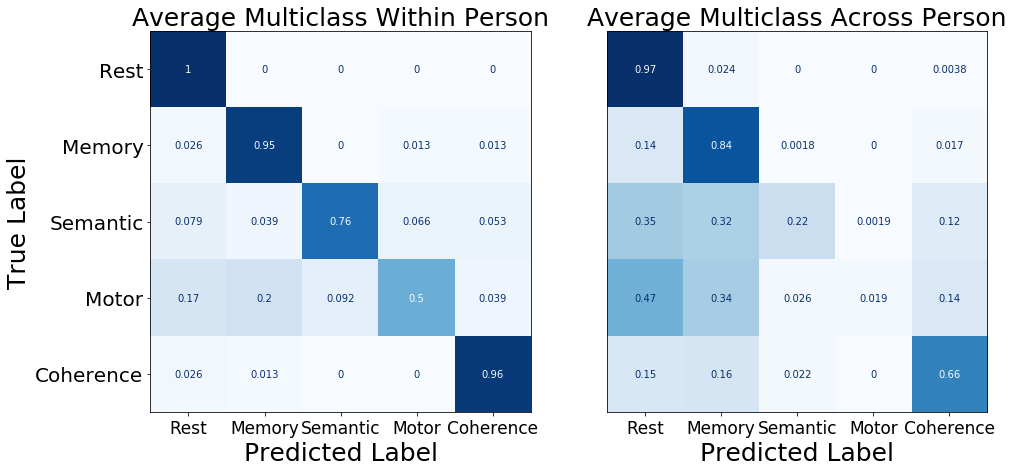

In [1]:
import seperate_task as st
st.multiclassAll()